In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
import lightgbm as lgb
# from sklearn.datasets import make_regression

import warnings

color = sns.color_palette()

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
property_data = pd.read_csv("../Desktop/Zillow/properties_2016.csv") #Read Property Data

property_data.shape

(2985217, 58)

[<matplotlib.text.Text at 0x12bb3b780>, <matplotlib.text.Text at 0x1514a4ef0>]

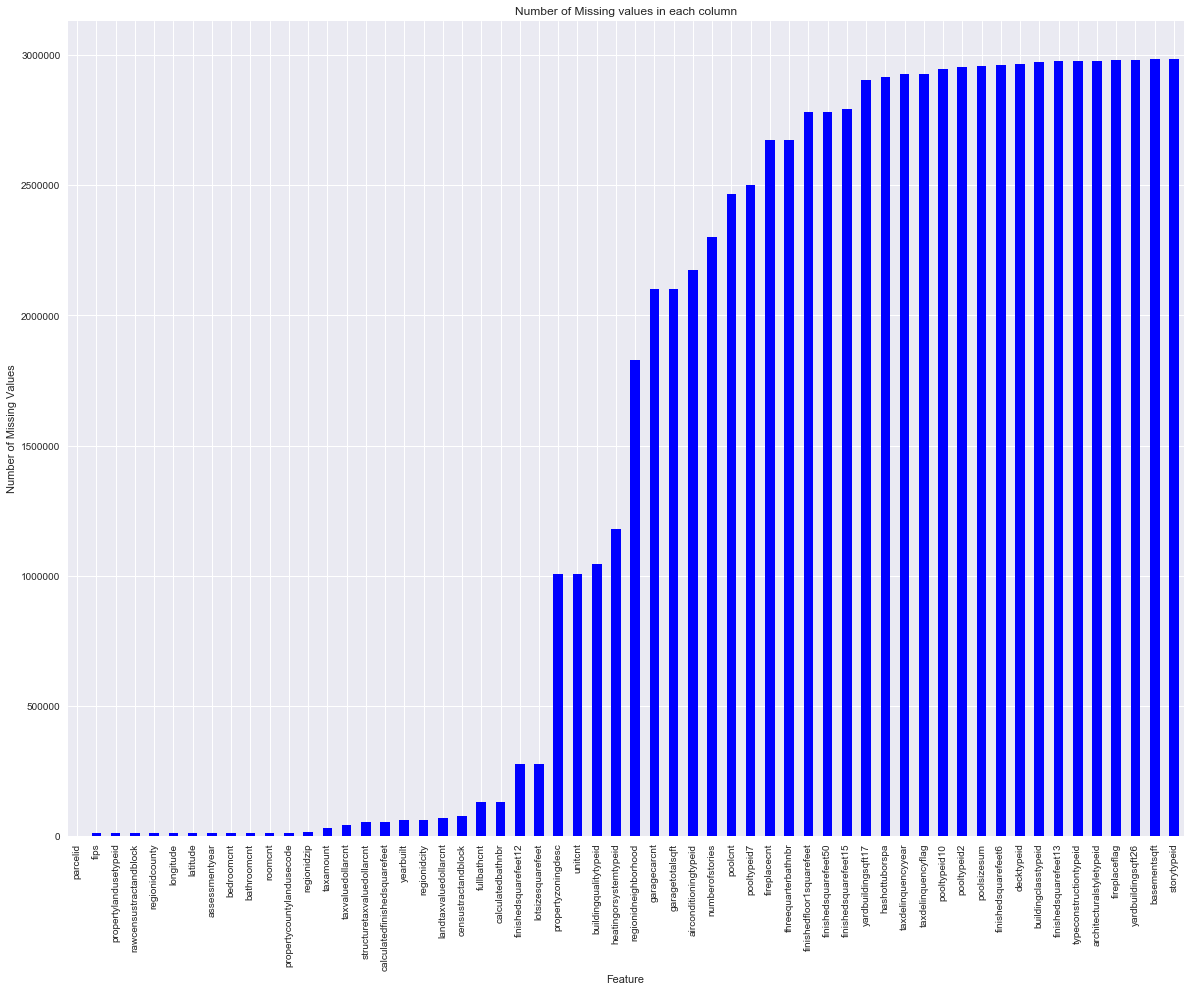

In [3]:
#Analysing each column for missing values

missing_data=property_data.isnull().sum(axis=0).sort_values()

ax=missing_data.plot.bar(figsize=(20,15), title='Number of Missing values in each column',color='blue')

ax.set(xlabel="Feature", ylabel="Number of Missing Values")

In [4]:
#drop columns having more than 50% missing data
output=property_data.dropna(thresh=0.5*len(property_data), axis=1) 

In [5]:
#As we can see, we have two columns whose data types are 'objects', so we need to drop them before replacing with mean values
category_cols=output.select_dtypes(['object']).columns
output.drop(output[category_cols],axis=1, inplace=True)
output.head()


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,10754147,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,...,96337.0,0.0,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN
1,10759547,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,...,96337.0,0.0,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN
2,10843547,0.0,0.0,NaN,NaN,73026.0,NaN,6037.0,NaN,NaN,...,96095.0,0.0,2.0,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN
3,10859147,0.0,0.0,7.0,NaN,5068.0,NaN,6037.0,NaN,NaN,...,96424.0,0.0,NaN,1948.0,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN
4,10879947,0.0,0.0,NaN,NaN,1776.0,NaN,6037.0,NaN,NaN,...,96450.0,0.0,1.0,1947.0,193796.0,433491.0,2015.0,239695.0,5725.17,NaN


In [6]:
#fill missing values with mean
for column in output.columns:
    output[column]=output[column].fillna(output[column].mean())


In [7]:
train_data= pd.read_csv("../Desktop/Zillow/train_2016_v2.csv") #Read Train Data

train_data.shape

train_data.head()
output.shape

(2985217, 27)

In [8]:
#perform join operation on property and train data table with common parcelid

merged = output.merge(train_data, on='parcelid') 

#merged.to_csv("output.csv", index=False)

# output=pd.read_csv("../Desktop/output.csv")

merged.shape

(90275, 29)

In [9]:
# drop parcel id and transaction date to evaluate correaltion

output_new = merged.drop(['parcelid', 'transactiondate'], axis=1)

In [10]:
output_new.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
0,2.5,3.0,5.784787,2.5,1264.0,1264.0,6111.0,2.0,4.012053,34303597.0,...,5.0,1.181171,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953
1,1.0,2.0,5.784787,1.0,777.0,777.0,6111.0,1.0,4.012053,34272866.0,...,4.0,1.181171,1990.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,0.0198
2,2.0,3.0,5.784787,2.0,1101.0,1101.0,6111.0,2.0,4.012053,34340801.0,...,5.0,1.181171,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060
3,1.5,2.0,5.784787,1.5,1554.0,1554.0,6111.0,1.0,4.012053,34354313.0,...,5.0,1.181171,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566
4,2.5,4.0,5.784787,2.5,2415.0,2415.0,6111.0,2.0,4.012053,34266578.0,...,8.0,1.181171,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573


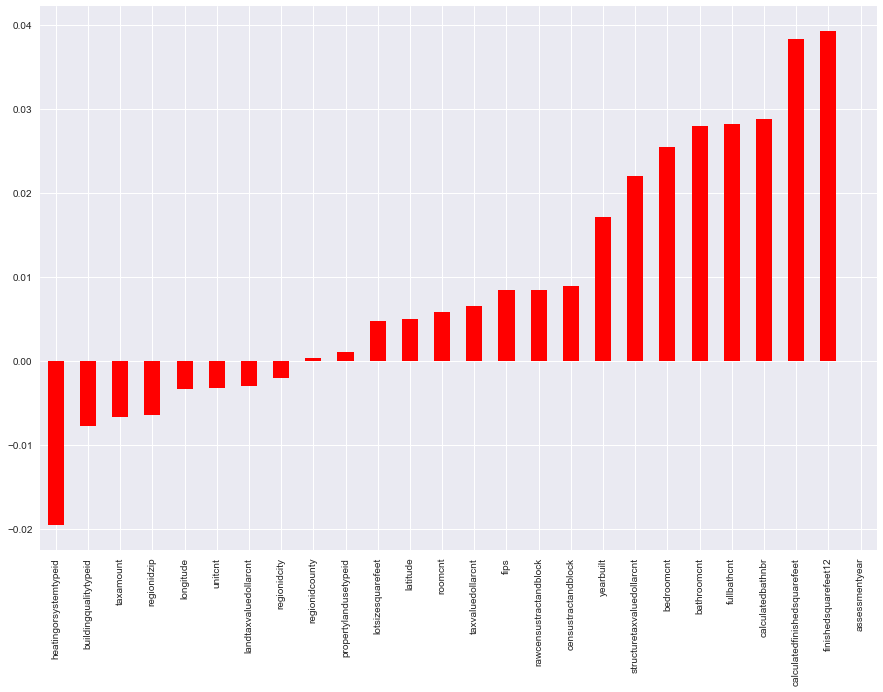

In [11]:
#plot correlation of each reamining column with logerror

corr_data=output_new.corr().ix['logerror', :-1].sort_values()
    
corr_data.plot.bar(figsize=(15,10), color='red') 

In [12]:
x_cols = [col for col in output_new.columns if col not in ['logerror'] if output_new[col].dtype=='float64']
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(output_new[col].values, output_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values}).sort_values(by='corr_values')

In [13]:
#As we can see, overall correlation values are very small. Let us take the variables with high correlation values.

corr_high = corr_df.ix[(corr_df['corr_values']>0.01) | (corr_df['corr_values'] < -0.005)]
corr_high

,col_labels,corr_values
8,heatingorsystemtypeid,-0.019605
2,buildingqualitytypeid,-0.007733
24,taxamount,-0.006671
16,regionidzip,-0.006499
19,yearbuilt,0.017127
20,structuretaxvaluedollarcnt,0.021999
1,bedroomcnt,0.025467
0,bathroomcnt,0.027889
7,fullbathcnt,0.028169
3,calculatedbathnbr,0.028759


In [14]:
#Columns to use for plotting heatmap i.e. columns with high correlations:

corr_heatmap = corr_high.col_labels.tolist()

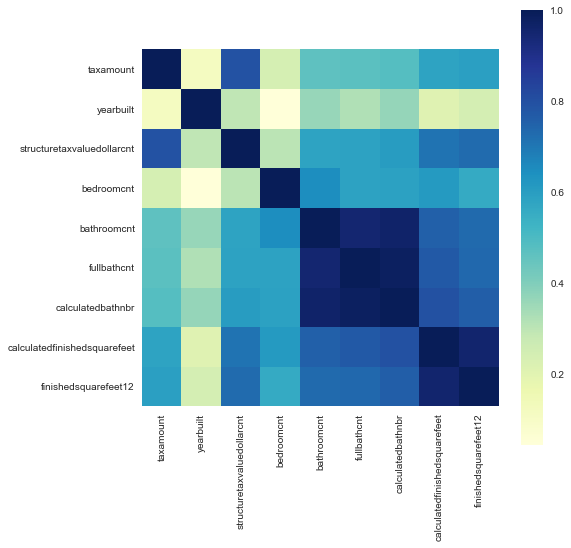

In [15]:
# Let us draw the heatmap to see the correlations among variables 
category_value = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','taxdelinquencyflag']

numeric_col = [x for x in corr_heatmap if x not in category_value]

#The following heatmap shows what all variables are correlated.
plt.figure(figsize = (8,8))

sns.heatmap(data=output_new[numeric_col].corr(), vmax=1., square=True,cmap="YlGnBu")

plt.show()

plt.gcf().clear()

In [16]:
categorical_value = ['airconditioningtypeid','buildingqualitytypeid','fips','heatingorsystemtypeid','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip']


In [17]:
output_new.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
0,2.5,3.0,5.784787,2.5,1264.0,1264.0,6111.0,2.0,4.012053,34303597.0,...,5.0,1.181171,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953
1,1.0,2.0,5.784787,1.0,777.0,777.0,6111.0,1.0,4.012053,34272866.0,...,4.0,1.181171,1990.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,0.0198
2,2.0,3.0,5.784787,2.0,1101.0,1101.0,6111.0,2.0,4.012053,34340801.0,...,5.0,1.181171,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060
3,1.5,2.0,5.784787,1.5,1554.0,1554.0,6111.0,1.0,4.012053,34354313.0,...,5.0,1.181171,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566
4,2.5,4.0,5.784787,2.5,2415.0,2415.0,6111.0,2.0,4.012053,34266578.0,...,8.0,1.181171,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573


In [18]:
drop_col = [x for x in output_new.columns if x in categorical_value]
output_new = output_new.drop(drop_col, axis=1)

In [19]:
output_new.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
0,2.5,3.0,2.5,1264.0,1264.0,2.0,34303597.0,-119287236.0,1735.000000,5.0,1.181171,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953
1,1.0,2.0,1.0,777.0,777.0,1.0,34272866.0,-119198911.0,22822.805528,4.0,1.181171,1990.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,0.0198
2,2.0,3.0,2.0,1101.0,1101.0,2.0,34340801.0,-119079610.0,6569.000000,5.0,1.181171,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060
3,1.5,2.0,1.5,1554.0,1554.0,1.0,34354313.0,-119076405.0,7400.000000,5.0,1.181171,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566
4,2.5,4.0,2.5,2415.0,2415.0,2.0,34266578.0,-119165392.0,6326.000000,8.0,1.181171,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573


In [20]:
#we need logerror
corr_heatmap.append('logerror')

low_corr=[x for x in output_new.columns if x not in corr_heatmap]
output_new=output_new.drop(low_corr, axis=1)

In [21]:
output_new.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,yearbuilt,structuretaxvaluedollarcnt,taxamount,logerror
0,2.5,3.0,2.5,1264.0,1264.0,2.0,1986.0,115087.0,2015.06,0.0953
1,1.0,2.0,1.0,777.0,777.0,1.0,1990.0,143809.0,2581.30,0.0198
2,2.0,3.0,2.0,1101.0,1101.0,2.0,1956.0,33619.0,591.64,0.0060
3,1.5,2.0,1.5,1554.0,1554.0,1.0,1965.0,45609.0,682.78,-0.0566
4,2.5,4.0,2.5,2415.0,2415.0,2.0,1984.0,277000.0,5886.92,0.0573


In [22]:
x_pre_train=output_new.drop('logerror',axis=1)
y_pre_train=output_new['logerror']

x_train, x_test, y_train, y_test = train_test_split(x_pre_train, y_pre_train, test_size=0.20)


In [23]:
x_train.head()


,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,yearbuilt,structuretaxvaluedollarcnt,taxamount
73791,2.5,4.0,2.500000,2222.000000,2222.000000,2.000000,1983.000000,216574.000000,3184.56
66170,2.5,3.0,2.500000,1826.000000,1826.000000,2.000000,1986.000000,250511.000000,5638.16
30352,1.0,2.0,1.000000,1008.000000,1008.000000,1.000000,1925.000000,12423.000000,690.97
72538,2.5,3.0,2.500000,1946.000000,1946.000000,2.000000,1964.000000,249186.000000,4877.84
31931,0.0,0.0,2.299263,1827.162124,1760.000608,2.244165,1964.261641,170883.577166,4267.51


In [24]:
len(y_train)

72220

In [25]:
regression = linear_model.LinearRegression()

# Train the model using the training sets
regression.fit(x_train, y_train)




LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
#predict on test data (20%)
# citation: used from http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
y_prediction = regression.predict(x_test)

print('Coefficients: \n', regression.coef_)
# The mean squared error
print("Mean squared error: %.6f"
      % mean_squared_error(y_test, y_prediction))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.6f' % r2_score(y_test, y_prediction))


Coefficients: 
 [ -1.89068215e-03   1.19526772e-04  -3.22004557e-03   4.89958634e-06
   7.12871819e-06   4.08957324e-03   6.72467956e-06   2.05934042e-08
  -1.55072064e-06]
Mean squared error: 0.028726
Variance score: 0.001247


In [27]:
prop_test=property_data[x_train.columns]
prop_test.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,yearbuilt,structuretaxvaluedollarcnt,taxamount
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,NaN,73026.0,NaN,NaN,NaN,650756.0,20800.37
3,0.0,0.0,NaN,5068.0,NaN,NaN,1948.0,571346.0,14557.57
4,0.0,0.0,NaN,1776.0,NaN,NaN,1947.0,193796.0,5725.17


In [28]:
for column in prop_test.columns:
    prop_test[column]=prop_test[column].fillna(prop_test[column].mean())

In [29]:
prop_test.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,yearbuilt,structuretaxvaluedollarcnt,taxamount
0,0.0,0.0,2.299263,1827.162124,1760.000608,2.244165,1964.261641,170883.577166,5377.607139
1,0.0,0.0,2.299263,1827.162124,1760.000608,2.244165,1964.261641,170883.577166,5377.607139
2,0.0,0.0,2.299263,73026.000000,1760.000608,2.244165,1964.261641,650756.000000,20800.370000
3,0.0,0.0,2.299263,5068.000000,1760.000608,2.244165,1948.000000,571346.000000,14557.570000
4,0.0,0.0,2.299263,1776.000000,1760.000608,2.244165,1947.000000,193796.000000,5725.170000


In [30]:
# Make predictions using the testing set

prop_prediction = regression.predict(prop_test)

In [31]:
len(prop_prediction)

2985217

In [32]:
submission = pd.read_csv("../Desktop/Zillow/sample_submission.csv") #Read Sample_submission file
submission.head()


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [33]:
for col in submission.columns:
    if col!='ParcelId':
        submission[col]=prop_prediction

In [34]:
submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.017152,0.017152,0.017152,0.017152,0.017152,0.017152
1,10759547,0.017152,0.017152,0.017152,0.017152,0.017152,0.017152
2,10843547,0.351962,0.351962,0.351962,0.351962,0.351962,0.351962
3,10859147,0.026932,0.026932,0.026932,0.026932,0.026932,0.026932
4,10879947,0.016718,0.016718,0.016718,0.016718,0.016718,0.016718


In [35]:
submission.to_csv("../Desktop/Zillow/LinearRegression.csv.gz", index=False, compression='gzip', float_format='%.6f')

In [36]:
# Now let us proceed to another model :random forest model

# X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
random_rgr = RandomForestRegressor()
random_rgr.fit(x_train, y_train)
RandomForestRegressor(bootstrap=True,criterion='mse',max_depth=2,max_features='auto', max_leaf_nodes=None, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
print(random_rgr.feature_importances_)

[ 0.01816574  0.04719275  0.01614949  0.13359666  0.1137844   0.01186459
  0.1195716   0.2587282   0.28094658]


In [37]:
prop_random_pred = random_rgr.predict(prop_test)

In [38]:
submission_random = pd.read_csv("../Desktop/Zillow/sample_submission.csv") #Read Sample_submission file
for col in submission_random.columns:
    if col!='ParcelId':
        submission_random[col]=prop_random_pred
submission_random.to_csv("../Desktop/Zillow/RandomForestRegression.csv.gz", index=False, compression='gzip', float_format='%.6f')

In [39]:
#Trying yet another model: Gradient Boosting regression

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(x_train, y_train)
prop_gradient_pred= clf.predict(prop_test)


In [40]:
submission_gradient = pd.read_csv("../Desktop/Zillow/sample_submission.csv") #Read Sample_submission file
for col in submission_gradient.columns:
    if col!='ParcelId':
        submission_gradient[col]=prop_gradient_pred
submission_gradient.to_csv("../Desktop/Zillow/GradientBoostingRegression.csv.gz", index=False, compression='gzip', float_format='%.6f')

In [41]:
#trying yet another model: LigthGBM
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'mse'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

# predict
prop_lightgbm_pred = gbm.predict(prop_test, num_iteration=gbm.best_iteration)

[1]	valid_0's l2: 0.0287567	valid_0's l2: 0.0287567
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0287389	valid_0's l2: 0.0287389
[3]	valid_0's l2: 0.0287234	valid_0's l2: 0.0287234
[4]	valid_0's l2: 0.028711	valid_0's l2: 0.028711
[5]	valid_0's l2: 0.0287	valid_0's l2: 0.0287
[6]	valid_0's l2: 0.0286925	valid_0's l2: 0.0286925
[7]	valid_0's l2: 0.0286819	valid_0's l2: 0.0286819
[8]	valid_0's l2: 0.0286755	valid_0's l2: 0.0286755
[9]	valid_0's l2: 0.0286704	valid_0's l2: 0.0286704
[10]	valid_0's l2: 0.0286631	valid_0's l2: 0.0286631
[11]	valid_0's l2: 0.0286599	valid_0's l2: 0.0286599
[12]	valid_0's l2: 0.0286539	valid_0's l2: 0.0286539
[13]	valid_0's l2: 0.0286508	valid_0's l2: 0.0286508
[14]	valid_0's l2: 0.0286499	valid_0's l2: 0.0286499
[15]	valid_0's l2: 0.0286436	valid_0's l2: 0.0286436
[16]	valid_0's l2: 0.0286388	valid_0's l2: 0.0286388
[17]	valid_0's l2: 0.0286383	valid_0's l2: 0.0286383
[18]	valid_0's l2: 0.0286357	valid_0's l2: 0.0286357
[1